# Stochastic growth model

We now add randomness to the growth model. We do this by easing the assumption that in the steady state the technology stock is constant. We assume that 

$$A_t = \exp(\eta_t)$$

where 

$$\eta_t = \rho \eta_{t-1} + \varepsilon_t$$

follows a first order autoregressive process. This slightly changes our optimization problem:

The household optimizes his expected livetime utility:

$$E_0 \large[ \small\sum_{t=0}^{\infty} \beta^t u(c_t) | \eta_0 \large] \\
\textrm{s.t. } \exp(\eta_t)k_t^{\alpha} = c_t + k_{t+1} - (1-\delta) k_t \\
\textrm{and } \eta_{t+1} = \rho \eta_t + \varepsilon_{t+1} \quad \textrm{with } \quad \varepsilon_{t+1} ~ N(0, \sigma_{\varepsilon}^2)$$ 

We assume that the functional form on utiltiy is CRRA $u(c) = \frac{c^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}}$. Writing the problem recursively, we then need to solve the dynamic problem:

$$V(k_t, \eta_t) = \max_{c_t} \frac{c_t^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} + \beta E_t \large[ \small V(k_{t+1}, \eta_{t+1}) | n_t \large]  \\
\textrm{s.t. } \exp(\eta_t)k_t^{\alpha} = c_t + k_{t+1} - (1-\delta)k_t \\
\textrm{and } \eta_{t+1} = \rho \eta_t + \varepsilon_{t+1} \quad \textrm{with } \quad \varepsilon_{t+1} ~ N(0, \sigma_{\varepsilon}^2)$$

This problem would require to solve an infinite dimension problem, since $\eta_t$ can take on infinite values. Therefore, we discretize the AR(1) process to make it possible to numerically solve the model. Using the descritized shock, we then can write the optimization problem as follows:

$$V(k_i, \eta_j) = \max_{c_t} \frac{c_t^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} + \beta \sum_{j = 1}^m V(k_{i^+}, \eta_{j^+})   \\
\textrm{s.t. } \quad \exp(\eta_j)k_i^{\alpha} = c_t + k_{i^+} - (1-\delta)k_i $$

The first order condition of this problem results into the modified Euler equation:

$$c(k_i, \eta_j) = \Big[ \beta \sum_{j^+=1}^m \pi_{j,j^+}((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1})c(k_{i^+},\eta_j^+)^{-\frac{1}{\gamma}}\Big]^{-\gamma}$$

We can use this equation for policy function iteration.

In [1]:
import numpy as np
import scipy.interpolate as interp
import scipy.optimize as opt
import time
import sys
import scipy.stats as st
import scipy as sp
import matplotlib.pyplot as plt
from numba import jit

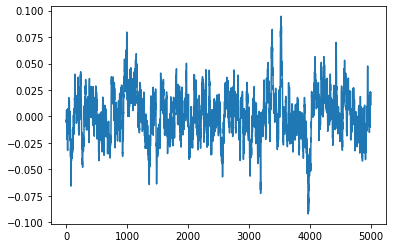

In [2]:
# Let us simulate the technology process
rho = 0.95
sigma = np.sqrt(0.000049)

# Setting up the time periods and the number of states
T = 5000
NS = 3

# Generating random numbers
v = np.random.normal(0, sigma, T)

eta = np.zeros(T+1)
eta[0] = 0

for t in np.arange(T):
    eta[t+1] = rho*eta[t] + v[t]

eta = eta[1:]
    
# Plotting the series
plt.plot(eta)
plt.show()

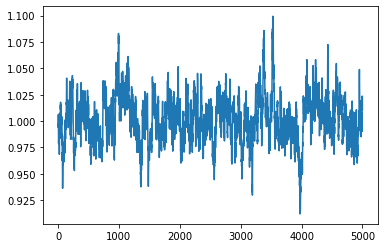

In [3]:
# Transforming the series into levels
A = np.exp(eta)

# Plotting A
plt.plot(A)
plt.show()

We now discretize the series using the Rouwenhorst (1995) algorithm.

In [4]:
# Discretization using Rouwenhorst (1995)

def rouwen(rho, mu, sigma, num):
    
    '''
    Function Rouwen based on Rouwenhorst (1995)
    
    Purpose:    Construct transition probability matrix for discretizing an
                AR(1) y_t = rho y_(t-1) + eps_t process.
                
    Format:     {dscSp, transP} = rouwen(rho, mu, sigma, num)

    Inputs:
                rho: persistence (close to one)
                mu: mean and the middle point of the discrete state space]
                sigma: unconditional std.dev of the process y_t
                num: number of grid points on the discretized process

    Output:
                dscSp: discrete state space (num by 1 vector)
                transP: transition probability matrix over the grid
    '''

    dscSp = np.linspace(-(num-1)**(1/2)*sigma, (num-1)**(1/2)*sigma, num).T

    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T

    while transP.shape[0] <= num - 1:

        len_P = transP.shape[0]
        transP = p*np.vstack((np.hstack((transP,np.zeros((len_P,1)))), np.zeros((1, len_P+1)))) \
        + (1-p)*np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
        + (1-q)*np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
        + q*np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.

    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return dscSp, transP

We can use a simulation function to replicate the original function. The function below simulates a descritized version of the continuous technology process, as defined above.

In [5]:
def mcsim(states, transM, num_sim, start, draw, mu, sigma):
    '''
    Function to simulate a discretizised Markow-Chain-Process
    
    Purpose:    Using the generated estimation for the Markow-Chain,
                simulate a series, which mimics the behavior of the series.
                
    Format:     {sim} = simdiscmc(states, transM, num_sim)
    
    Inputs:     states  = Matrix with the states, generated by tauchen or rouwen
                transM  = Transition matrix from of the same functions
                num_sim = length of the series to simulate
                start   = starting state for the simulation of the Markow-Chain
                draw    = errors from the original series
                mu      = unconditional mean of the error
                sigma   = standard deviation of the error
                
    Output:     chain   = descretizised series of simulated values
    '''
    r = transM.shape[0]
    X = np.zeros((num_sim,1))
    X = st.norm.cdf(draw, loc = mu, scale = sigma)
    s = np.zeros((r,1))
    state = np.zeros((r,num_sim))
    s[start-1,0] = 1
    m = np.ones((transM.shape[0],transM.shape[0]))
    cum = np.dot(transM, np.triu(m))
    temp = np.zeros((1,2))
    for i in range(X.shape[0]):
        state[:,i] = s[:,0]
        temp = np.dot(np.transpose(s),cum)
        ppi = np.zeros([1,1])
        ppi = np.hstack((ppi, temp))
        a = (ppi[0,1:r+1] > X[i])
        b = (X[i] > ppi[0,0:r])
        s1 = np.array(np.transpose(np.multiply(a, b)))
        for j in range(r):
            s[j,0] = s1[j]
    chain = np.dot(np.transpose(states), state)
    return chain

Doing this now for the series above:

In [6]:
# Extracting the states and the transition probabilites
s, pi = rouwen(rho, 0, (sigma**2/(1-rho**2))**(1/2), NS)

# Extracting the simulated series for technology
etasim = mcsim(s, pi, T, int(np.round((NS)/2)), v, 0, sigma)
Asim = np.exp(etasim)

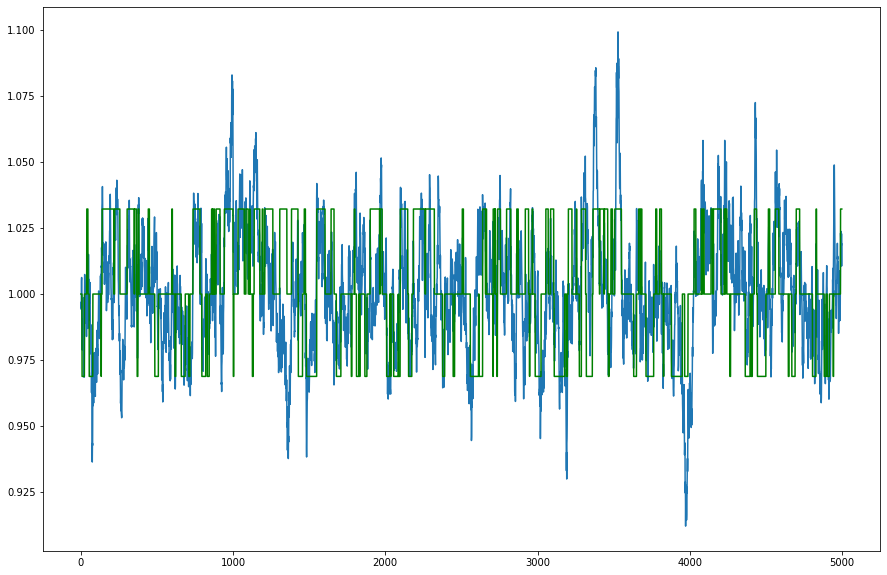

In [7]:
# Plotting
plt.figure(figsize = (15,10))
plt.plot(np.arange(T), A)
plt.plot(np.arange(T), Asim, color = 'green')
plt.show()

The simulated descritized series mimics well the real series. Consequently, we will use the series below for the dynamic programming.

In [8]:
# Setting up the values for the model
parameters = np.zeros(5)
parameters[0] = 0.4         # Alpha
parameters[1] = 0.99        # Beta
parameters[2] = 0.5         # Gamma
parameters[3] = 0.019       # Delta

# Printing the kss for setting up the grids sensible
kss = (parameters[0]*parameters[1]/(1-parameters[1]*(1-parameters[3])))**(1/(1-parameters[0]))
print("The steady state value for capital is %F." % kss)

# Setting up the values for the grid
kmin = 60
kmax = 100
knum = 10

if kss > kmax or kss < kmin:
    sys.exit("The grid must contain the steady state. Adapt kmax and kmin accordingly.")
elif kmax < 1.2*kss:
    sys.exit("The grid must contain the 1.2 times the steady state. Adapt kmax accordingly.")


The steady state value for capital is 78.871460.


In [9]:
# Create a grid for capital

def initialize(start, end, n, guess = 0):
    """Function initializing the capital grid and an initial guess for the value function
    
    Inputs:
    start         = start value for the capital grid
    end           = end point for the capital grid
    n             = number of grid points for the grid
    guess         = Initial guess for the value function
    
    
    Outputs:
    capital       = discretized capital grid
    value         = initial guess for the value function"""
    
    
    capital = np.linspace(start, end, n)
    value = np.ones((n,))*guess
    
    return capital, value


# Testing areas
capital, value = initialize(kmin, kmax, knum)

The policy function iterates on the Euler equation and makes it zero:

$$c(k_i, \eta_j) = \Big[ \beta \sum_{j^+=1}^m \pi_{j,j^+}((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1})c(k_{i^+},\eta_j^+)^{-\frac{1}{\gamma}}\Big]^{-\gamma}$$

In [10]:
# Generating a matrix which relates the two state variables
sbar, kbar = np.meshgrid(s, capital)   

# Initial guess for the policy function
guess = np.exp(sbar)*kbar**parameters[0] - parameters[3]*kbar # Guessing the initial level to be the steady state level
guess = guess**(1-1/parameters[2])/((1-1/parameters[2])*(1-parameters[1]))

print(guess[-10:])

[[-26.02127175 -24.97801437 -23.98540413]
 [-25.62097101 -24.58078717 -23.5921197 ]
 [-25.2701826  -24.231477   -23.24522779]
 [-24.96165259 -23.92303719 -22.9378845 ]
 [-24.68958342 -23.64983419 -22.66461696]
 [-24.44927953 -23.40730363 -22.42098973]
 [-24.23689305 -23.1917037  -22.20336546]
 [-24.049238   -22.9999348  -22.00872994]
 [-23.88365204 -22.82940535 -21.83456187]
 [-23.73789201 -22.67793047 -21.67873456]]


We had so far the first order condition:

$$c(k_i, \eta_j) - \Big[ \beta \sum_{j^+=1}^m \pi_{j,j^+}\big((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1}\big)c(k_{i^+},\eta_j^+)^{-\frac{1}{\gamma}}\Big]^{-\gamma} $$

We now use the budget constraint $c = (1-\delta)k_{i} + k_{i}^\alpha - k_{i^+}$ in both periods and the guess for the policy function $S(k_{i^+},\eta_{j^+})$

$$
(1-\delta)k_i + \exp(\eta_j)k_i^\alpha - k_{i^+} - \Big[ \beta \sum_{i^+=1}^m \pi_{i,i^+}\big((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1}\big)S(k_{i^+},\eta_{j^+})^{-\frac{1}{\gamma}}\Big]^{-\gamma} $$

We can transform this equation now with the generated weight above:

$$
(1-\delta)k_i + \exp(\eta_j)k_i^\alpha - k_{i^+} - \Big[ \beta \sum_{i^+=1}^m \hat{\pi}_{i,i^+,j}S(k_{j^+},\eta_{j^+})^{-\frac{1}{\gamma}}\Big]^{-\gamma} $$

In [12]:
def euler(cap, state, guess, capital, states, parameters):
    """Function giving back the exact value for future capital which solves the first order condition
    
    Inputs:
    
    cap         =      value for capital for which the euler equation is evaluated
    state       =      current index of the state variable technology
    guess       =      guess for the policy function in form of an interpolated function
    capital     =      matrix for capital, used in the interpolation
    states      =      matrix of the possible values that capital can take
    parameters  =      Parameters given for the problem
    
    
    Output:
    
    loc     =      value for future capital which solves the euler equation
    
    """
    
    alpha = parameters[0]
    beta = parameters[1]
    gamma = parameters[2]
    delta = parameters[3]
    kss = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
    
    # Define consumption tomorrow as a function of capital tomorrow and technology tomorrow
    sbar, kbar = np.meshgrid(states, capital)
    rbfi = interp.Rbf(sbar, kbar, guess)
    di = rbfi(sbar, kbar)
    cont = sp.interpolate.interp2d(sbar, kbar, di, kind = 'cubic')
    
    # Calculate the interest rate at a certain point
    interest = lambda cap1, eta1: (1-delta)+alpha*np.exp(eta1)*cap1**(alpha-1) 
    
    # Get the sum of the marginal utilites (SMU)
    NS = np.shape(states)[0]
    SMU = 0
    for j in np.arange(NS):
        SMU = SMU + (pi[state,j]*interest(capital,states[j])*cont(capital, states[j])**(-1/gamma))
    
    # We need to interpolate the function with respect to capital, again
    tck = interp.splrep(capital, SMU, k = 3)
    y_app_spl = lambda x: interp.splev(x, tck)
    
    # Defining consumption today as a function of cap1
    con = lambda cap1: (1-delta)*cap + np.exp(states[state])*cap**alpha - cap1
    
    # Evaluating the residual as a function of future capital
    res = lambda cap1: con(cap1) - (beta*y_app_spl(cap1))**(-gamma)
    loc = opt.fsolve(res, kss)        # We use kss here, since this makes the optimization stable
    return loc[0]


# Testing area
alpha = parameters[0]
beta = parameters[1]
gamma = parameters[2]
delta = parameters[3]
kss = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
loc = euler(kss, int((NS-1)/2), guess, capital, s, parameters)
print(loc, kss)

TypingError: Failed in nopython mode pipeline (step: convert make_function into JIT functions)
[1mCannot capture the non-constant value associated with variable 'tck' in a function that will escape.
[1m
File "<ipython-input-12-98f24745d096>", line 44:[0m
[1mdef euler(cap, state, guess, capital, states, parameters):
    <source elided>
    tck = interp.splrep(capital, SMU, k = 3)
[1m    y_app_spl = lambda x: interp.splev(x, tck)
[0m    [1m^[0m[0m
[0m

In [12]:
np.shape(s)

(3,)

#### Actual policy function iteration

In [18]:
# Policy function iteration
def pfi(capital, states, guess, parameters):
    """Define the function"""
    
    start = time.time()
    new = np.zeros((knum,NS))
    iteration = 0
    error = 1
    while error > 0.0001 and iteration < 5000:
        iteration += 1
        
        # Until convergence, generate a new policy function based on the current capital stock and the euler solution
        for index1, k in enumerate(capital):
            for index2, s in enumerate(states): 
                # Generate a new policy function
                new[index1,index2] = np.exp(s)*k**parameters[0] - euler(k, index2, guess, capital, states, parameters) + (1-parameters[3])*k
    
        # Calculating the error
        error = np.absolute(np.max((new - guess)/guess))
    
        # Updating the policy function which is employed in the next iteration round
        guess = np.copy(new)
        print("\n Iteration %1.F, with an error of %f" % (iteration, error))
    
    end = time.time()

    print("\nPolicy function iteration took %1.F iterations, and took %f seconds." % (iteration, end - start))
    return guess

# Testing area
guess = pfi(capital, s, guess, parameters)

C:\Users\Fabio\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=10,10 m=30 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 1, with an error of 0.002422

 Iteration 2, with an error of 0.002421

 Iteration 3, with an error of 0.002421

 Iteration 4, with an error of 0.002421

 Iteration 5, with an error of 0.002421

 Iteration 6, with an error of 0.002421

 Iteration 7, with an error of 0.002421

 Iteration 8, with an error of 0.002421

 Iteration 9, with an error of 0.002421

 Iteration 10, with an error of 0.002421

 Iteration 11, with an error of 0.002421

 Iteration 12, with an error of 0.002421

 Iteration 13, with an error of 0.002421

 Iteration 14, with an error of 0.002421

 Iteration 15, with an error of 0.002420

 Iteration 16, with an error of 0.002420

 Iteration 17, with an error of 0.002420

 Iteration 18, with an error of 0.002420

 Iteration 19, with an error of 0.002420

 Iteration 20, with an error of 0.002420

 Iteration 21, with an error of 0.002420

 Iteration 22, with an error of 0.002420

 Iteration 23, with an error of 0.002420

 Iteration 24, with an error of 0.002420




 Iteration 197, with an error of 0.002409

 Iteration 198, with an error of 0.002409

 Iteration 199, with an error of 0.002409

 Iteration 200, with an error of 0.002409

 Iteration 201, with an error of 0.002409

 Iteration 202, with an error of 0.002409

 Iteration 203, with an error of 0.002409

 Iteration 204, with an error of 0.002409

 Iteration 205, with an error of 0.002409

 Iteration 206, with an error of 0.002409

 Iteration 207, with an error of 0.002409

 Iteration 208, with an error of 0.002408

 Iteration 209, with an error of 0.002408

 Iteration 210, with an error of 0.002408

 Iteration 211, with an error of 0.002408

 Iteration 212, with an error of 0.002408

 Iteration 213, with an error of 0.002408

 Iteration 214, with an error of 0.002408

 Iteration 215, with an error of 0.002408

 Iteration 216, with an error of 0.002408

 Iteration 217, with an error of 0.002408

 Iteration 218, with an error of 0.002408

 Iteration 219, with an error of 0.002408

 Iteration

 Iteration 389, with an error of 0.002401

 Iteration 390, with an error of 0.002401

 Iteration 391, with an error of 0.002401

 Iteration 392, with an error of 0.002401

 Iteration 393, with an error of 0.002401

 Iteration 394, with an error of 0.002401

 Iteration 395, with an error of 0.002401

 Iteration 396, with an error of 0.002401

 Iteration 397, with an error of 0.002401

 Iteration 398, with an error of 0.002401

 Iteration 399, with an error of 0.002401

 Iteration 400, with an error of 0.002401

 Iteration 401, with an error of 0.002401

 Iteration 402, with an error of 0.002401

 Iteration 403, with an error of 0.002401

 Iteration 404, with an error of 0.002401

 Iteration 405, with an error of 0.002401

 Iteration 406, with an error of 0.002401

 Iteration 407, with an error of 0.002401

 Iteration 408, with an error of 0.002401

 Iteration 409, with an error of 0.002401

 Iteration 410, with an error of 0.002401

 Iteration 411, with an error of 0.002401

 Iteration 


 Iteration 581, with an error of 0.002397

 Iteration 582, with an error of 0.002397

 Iteration 583, with an error of 0.002397

 Iteration 584, with an error of 0.002397

 Iteration 585, with an error of 0.002396

 Iteration 586, with an error of 0.002396

 Iteration 587, with an error of 0.002396

 Iteration 588, with an error of 0.002396

 Iteration 589, with an error of 0.002396

 Iteration 590, with an error of 0.002396

 Iteration 591, with an error of 0.002396

 Iteration 592, with an error of 0.002396

 Iteration 593, with an error of 0.002396

 Iteration 594, with an error of 0.002396

 Iteration 595, with an error of 0.002396

 Iteration 596, with an error of 0.002396

 Iteration 597, with an error of 0.002396

 Iteration 598, with an error of 0.002396

 Iteration 599, with an error of 0.002396

 Iteration 600, with an error of 0.002396

 Iteration 601, with an error of 0.002396

 Iteration 602, with an error of 0.002396

 Iteration 603, with an error of 0.002396

 Iteration

 Iteration 772, with an error of 0.002394

 Iteration 773, with an error of 0.002394

 Iteration 774, with an error of 0.002394

 Iteration 775, with an error of 0.002394

 Iteration 776, with an error of 0.002394

 Iteration 777, with an error of 0.002394

 Iteration 778, with an error of 0.002393

 Iteration 779, with an error of 0.002393

 Iteration 780, with an error of 0.002393

 Iteration 781, with an error of 0.002393

 Iteration 782, with an error of 0.002393

 Iteration 783, with an error of 0.002393

 Iteration 784, with an error of 0.002393

 Iteration 785, with an error of 0.002393

 Iteration 786, with an error of 0.002393

 Iteration 787, with an error of 0.002393

 Iteration 788, with an error of 0.002393

 Iteration 789, with an error of 0.002393

 Iteration 790, with an error of 0.002393

 Iteration 791, with an error of 0.002393

 Iteration 792, with an error of 0.002393

 Iteration 793, with an error of 0.002393

 Iteration 794, with an error of 0.002393

 Iteration 

 Iteration 1149, with an error of 0.002390

 Iteration 1150, with an error of 0.002390

 Iteration 1151, with an error of 0.002390

 Iteration 1152, with an error of 0.002390

 Iteration 1153, with an error of 0.002390

 Iteration 1154, with an error of 0.002390

 Iteration 1155, with an error of 0.002390

 Iteration 1156, with an error of 0.002390

 Iteration 1157, with an error of 0.002390

 Iteration 1158, with an error of 0.002390

 Iteration 1159, with an error of 0.002390

 Iteration 1160, with an error of 0.002390

 Iteration 1161, with an error of 0.002390

 Iteration 1162, with an error of 0.002390

 Iteration 1163, with an error of 0.002390

 Iteration 1164, with an error of 0.002390

 Iteration 1165, with an error of 0.002390

 Iteration 1166, with an error of 0.002390

 Iteration 1167, with an error of 0.002390

 Iteration 1168, with an error of 0.002390

 Iteration 1169, with an error of 0.002390

 Iteration 1170, with an error of 0.002390

 Iteration 1171, with an error o


 Iteration 1336, with an error of 0.002390

 Iteration 1337, with an error of 0.002390

 Iteration 1338, with an error of 0.002390

 Iteration 1339, with an error of 0.002390

 Iteration 1340, with an error of 0.002390

 Iteration 1341, with an error of 0.002390

 Iteration 1342, with an error of 0.002390

 Iteration 1343, with an error of 0.002390

 Iteration 1344, with an error of 0.002390

 Iteration 1345, with an error of 0.002390

 Iteration 1346, with an error of 0.002390

 Iteration 1347, with an error of 0.002390

 Iteration 1348, with an error of 0.002390

 Iteration 1349, with an error of 0.002390

 Iteration 1350, with an error of 0.002390

 Iteration 1351, with an error of 0.002390

 Iteration 1352, with an error of 0.002390

 Iteration 1353, with an error of 0.002390

 Iteration 1354, with an error of 0.002390

 Iteration 1355, with an error of 0.002390

 Iteration 1356, with an error of 0.002390

 Iteration 1357, with an error of 0.002390

 Iteration 1358, with an error 


 Iteration 1523, with an error of 0.002389

 Iteration 1524, with an error of 0.002389

 Iteration 1525, with an error of 0.002389

 Iteration 1526, with an error of 0.002389

 Iteration 1527, with an error of 0.002389

 Iteration 1528, with an error of 0.002389

 Iteration 1529, with an error of 0.002389

 Iteration 1530, with an error of 0.002389

 Iteration 1531, with an error of 0.002389

 Iteration 1532, with an error of 0.002389

 Iteration 1533, with an error of 0.002389

 Iteration 1534, with an error of 0.002389

 Iteration 1535, with an error of 0.002389

 Iteration 1536, with an error of 0.002389

 Iteration 1537, with an error of 0.002389

 Iteration 1538, with an error of 0.002389

 Iteration 1539, with an error of 0.002389

 Iteration 1540, with an error of 0.002389

 Iteration 1541, with an error of 0.002389

 Iteration 1542, with an error of 0.002389

 Iteration 1543, with an error of 0.002389

 Iteration 1544, with an error of 0.002389

 Iteration 1545, with an error 


 Iteration 1712, with an error of 0.002389

 Iteration 1713, with an error of 0.002389

 Iteration 1714, with an error of 0.002389

 Iteration 1715, with an error of 0.002389

 Iteration 1716, with an error of 0.002389

 Iteration 1717, with an error of 0.002389

 Iteration 1718, with an error of 0.002389

 Iteration 1719, with an error of 0.002389

 Iteration 1720, with an error of 0.002389

 Iteration 1721, with an error of 0.002389

 Iteration 1722, with an error of 0.002389

 Iteration 1723, with an error of 0.002389

 Iteration 1724, with an error of 0.002389

 Iteration 1725, with an error of 0.002389

 Iteration 1726, with an error of 0.002389

 Iteration 1727, with an error of 0.002389

 Iteration 1728, with an error of 0.002389

 Iteration 1729, with an error of 0.002389

 Iteration 1730, with an error of 0.002389

 Iteration 1731, with an error of 0.002389

 Iteration 1732, with an error of 0.002389

 Iteration 1733, with an error of 0.002389

 Iteration 1734, with an error 

 Iteration 1899, with an error of 0.002389

 Iteration 1900, with an error of 0.002389

 Iteration 1901, with an error of 0.002389

 Iteration 1902, with an error of 0.002389

 Iteration 1903, with an error of 0.002389

 Iteration 1904, with an error of 0.002389

 Iteration 1905, with an error of 0.002389

 Iteration 1906, with an error of 0.002389

 Iteration 1907, with an error of 0.002389

 Iteration 1908, with an error of 0.002389

 Iteration 1909, with an error of 0.002389

 Iteration 1910, with an error of 0.002389

 Iteration 1911, with an error of 0.002389

 Iteration 1912, with an error of 0.002389

 Iteration 1913, with an error of 0.002389

 Iteration 1914, with an error of 0.002389

 Iteration 1915, with an error of 0.002389

 Iteration 1916, with an error of 0.002389

 Iteration 1917, with an error of 0.002389

 Iteration 1918, with an error of 0.002389

 Iteration 1919, with an error of 0.002389

 Iteration 1920, with an error of 0.002389

 Iteration 1921, with an error o

 Iteration 2086, with an error of 0.002389

 Iteration 2087, with an error of 0.002389

 Iteration 2088, with an error of 0.002389

 Iteration 2089, with an error of 0.002389

 Iteration 2090, with an error of 0.002389

 Iteration 2091, with an error of 0.002389

 Iteration 2092, with an error of 0.002389

 Iteration 2093, with an error of 0.002389

 Iteration 2094, with an error of 0.002389

 Iteration 2095, with an error of 0.002389

 Iteration 2096, with an error of 0.002389

 Iteration 2097, with an error of 0.002389

 Iteration 2098, with an error of 0.002389

 Iteration 2099, with an error of 0.002389

 Iteration 2100, with an error of 0.002389

 Iteration 2101, with an error of 0.002389

 Iteration 2102, with an error of 0.002389

 Iteration 2103, with an error of 0.002389

 Iteration 2104, with an error of 0.002389

 Iteration 2105, with an error of 0.002389

 Iteration 2106, with an error of 0.002389

 Iteration 2107, with an error of 0.002389

 Iteration 2108, with an error o


 Iteration 2276, with an error of 0.002389

 Iteration 2277, with an error of 0.002389

 Iteration 2278, with an error of 0.002389

 Iteration 2279, with an error of 0.002389

 Iteration 2280, with an error of 0.002389

 Iteration 2281, with an error of 0.002389

 Iteration 2282, with an error of 0.002389

 Iteration 2283, with an error of 0.002389

 Iteration 2284, with an error of 0.002389

 Iteration 2285, with an error of 0.002389

 Iteration 2286, with an error of 0.002389

 Iteration 2287, with an error of 0.002389

 Iteration 2288, with an error of 0.002389

 Iteration 2289, with an error of 0.002389

 Iteration 2290, with an error of 0.002389

 Iteration 2291, with an error of 0.002389

 Iteration 2292, with an error of 0.002389

 Iteration 2293, with an error of 0.002389

 Iteration 2294, with an error of 0.002389

 Iteration 2295, with an error of 0.002389

 Iteration 2296, with an error of 0.002389

 Iteration 2297, with an error of 0.002389

 Iteration 2298, with an error 

 Iteration 2463, with an error of 0.002388

 Iteration 2464, with an error of 0.002388

 Iteration 2465, with an error of 0.002388

 Iteration 2466, with an error of 0.002388

 Iteration 2467, with an error of 0.002388

 Iteration 2468, with an error of 0.002388

 Iteration 2469, with an error of 0.002388

 Iteration 2470, with an error of 0.002388

 Iteration 2471, with an error of 0.002388

 Iteration 2472, with an error of 0.002388

 Iteration 2473, with an error of 0.002388

 Iteration 2474, with an error of 0.002388

 Iteration 2475, with an error of 0.002388

 Iteration 2476, with an error of 0.002388

 Iteration 2477, with an error of 0.002388

 Iteration 2478, with an error of 0.002388

 Iteration 2479, with an error of 0.002388

 Iteration 2480, with an error of 0.002388

 Iteration 2481, with an error of 0.002388

 Iteration 2482, with an error of 0.002388

 Iteration 2483, with an error of 0.002388

 Iteration 2484, with an error of 0.002388

 Iteration 2485, with an error o

 Iteration 2652, with an error of 0.002388

 Iteration 2653, with an error of 0.002388

 Iteration 2654, with an error of 0.002388

 Iteration 2655, with an error of 0.002388

 Iteration 2656, with an error of 0.002388

 Iteration 2657, with an error of 0.002388

 Iteration 2658, with an error of 0.002388

 Iteration 2659, with an error of 0.002388

 Iteration 2660, with an error of 0.002388

 Iteration 2661, with an error of 0.002388

 Iteration 2662, with an error of 0.002388

 Iteration 2663, with an error of 0.002388

 Iteration 2664, with an error of 0.002388

 Iteration 2665, with an error of 0.002388

 Iteration 2666, with an error of 0.002388

 Iteration 2667, with an error of 0.002388

 Iteration 2668, with an error of 0.002388

 Iteration 2669, with an error of 0.002388

 Iteration 2670, with an error of 0.002388

 Iteration 2671, with an error of 0.002388

 Iteration 2672, with an error of 0.002388

 Iteration 2673, with an error of 0.002388

 Iteration 2674, with an error o


 Iteration 2839, with an error of 0.002388

 Iteration 2840, with an error of 0.002388

 Iteration 2841, with an error of 0.002388

 Iteration 2842, with an error of 0.002388

 Iteration 2843, with an error of 0.002388

 Iteration 2844, with an error of 0.002388

 Iteration 2845, with an error of 0.002388

 Iteration 2846, with an error of 0.002388

 Iteration 2847, with an error of 0.002388

 Iteration 2848, with an error of 0.002388

 Iteration 2849, with an error of 0.002388

 Iteration 2850, with an error of 0.002388

 Iteration 2851, with an error of 0.002388

 Iteration 2852, with an error of 0.002388

 Iteration 2853, with an error of 0.002388

 Iteration 2854, with an error of 0.002388

 Iteration 2855, with an error of 0.002388

 Iteration 2856, with an error of 0.002388

 Iteration 2857, with an error of 0.002388

 Iteration 2858, with an error of 0.002388

 Iteration 2859, with an error of 0.002388

 Iteration 2860, with an error of 0.002388

 Iteration 2861, with an error 


 Iteration 3028, with an error of 0.002388

 Iteration 3029, with an error of 0.002388

 Iteration 3030, with an error of 0.002388

 Iteration 3031, with an error of 0.002388

 Iteration 3032, with an error of 0.002388

 Iteration 3033, with an error of 0.002388

 Iteration 3034, with an error of 0.002388

 Iteration 3035, with an error of 0.002388

 Iteration 3036, with an error of 0.002388

 Iteration 3037, with an error of 0.002388

 Iteration 3038, with an error of 0.002388

 Iteration 3039, with an error of 0.002388

 Iteration 3040, with an error of 0.002388

 Iteration 3041, with an error of 0.002388

 Iteration 3042, with an error of 0.002388

 Iteration 3043, with an error of 0.002388

 Iteration 3044, with an error of 0.002388

 Iteration 3045, with an error of 0.002388

 Iteration 3046, with an error of 0.002388

 Iteration 3047, with an error of 0.002388

 Iteration 3048, with an error of 0.002388

 Iteration 3049, with an error of 0.002388

 Iteration 3050, with an error 


 Iteration 3216, with an error of 0.002388

 Iteration 3217, with an error of 0.002388

 Iteration 3218, with an error of 0.002388

 Iteration 3219, with an error of 0.002388

 Iteration 3220, with an error of 0.002388

 Iteration 3221, with an error of 0.002388

 Iteration 3222, with an error of 0.002388

 Iteration 3223, with an error of 0.002388

 Iteration 3224, with an error of 0.002388

 Iteration 3225, with an error of 0.002388

 Iteration 3226, with an error of 0.002388

 Iteration 3227, with an error of 0.002388

 Iteration 3228, with an error of 0.002388

 Iteration 3229, with an error of 0.002388

 Iteration 3230, with an error of 0.002388

 Iteration 3231, with an error of 0.002388

 Iteration 3232, with an error of 0.002388

 Iteration 3233, with an error of 0.002388

 Iteration 3234, with an error of 0.002388

 Iteration 3235, with an error of 0.002388

 Iteration 3236, with an error of 0.002388

 Iteration 3237, with an error of 0.002388

 Iteration 3238, with an error 


 Iteration 3403, with an error of 0.002388

 Iteration 3404, with an error of 0.002388

 Iteration 3405, with an error of 0.002388

 Iteration 3406, with an error of 0.002388

 Iteration 3407, with an error of 0.002388

 Iteration 3408, with an error of 0.002388

 Iteration 3409, with an error of 0.002388

 Iteration 3410, with an error of 0.002388

 Iteration 3411, with an error of 0.002388

 Iteration 3412, with an error of 0.002388

 Iteration 3413, with an error of 0.002388

 Iteration 3414, with an error of 0.002388

 Iteration 3415, with an error of 0.002388

 Iteration 3416, with an error of 0.002388

 Iteration 3417, with an error of 0.002388

 Iteration 3418, with an error of 0.002388

 Iteration 3419, with an error of 0.002388

 Iteration 3420, with an error of 0.002388

 Iteration 3421, with an error of 0.002388

 Iteration 3422, with an error of 0.002388

 Iteration 3423, with an error of 0.002388

 Iteration 3424, with an error of 0.002388

 Iteration 3425, with an error 


 Iteration 3591, with an error of 0.002388

 Iteration 3592, with an error of 0.002388

 Iteration 3593, with an error of 0.002388

 Iteration 3594, with an error of 0.002388

 Iteration 3595, with an error of 0.002388

 Iteration 3596, with an error of 0.002388

 Iteration 3597, with an error of 0.002388

 Iteration 3598, with an error of 0.002388

 Iteration 3599, with an error of 0.002388

 Iteration 3600, with an error of 0.002388

 Iteration 3601, with an error of 0.002388

 Iteration 3602, with an error of 0.002388

 Iteration 3603, with an error of 0.002388

 Iteration 3604, with an error of 0.002388

 Iteration 3605, with an error of 0.002388

 Iteration 3606, with an error of 0.002388

 Iteration 3607, with an error of 0.002388

 Iteration 3608, with an error of 0.002388

 Iteration 3609, with an error of 0.002388

 Iteration 3610, with an error of 0.002388

 Iteration 3611, with an error of 0.002388

 Iteration 3612, with an error of 0.002388

 Iteration 3613, with an error 


 Iteration 3780, with an error of 0.002388

 Iteration 3781, with an error of 0.002388

 Iteration 3782, with an error of 0.002388

 Iteration 3783, with an error of 0.002388

 Iteration 3784, with an error of 0.002388

 Iteration 3785, with an error of 0.002388

 Iteration 3786, with an error of 0.002388

 Iteration 3787, with an error of 0.002388

 Iteration 3788, with an error of 0.002388

 Iteration 3789, with an error of 0.002388

 Iteration 3790, with an error of 0.002388

 Iteration 3791, with an error of 0.002388

 Iteration 3792, with an error of 0.002388

 Iteration 3793, with an error of 0.002388

 Iteration 3794, with an error of 0.002388

 Iteration 3795, with an error of 0.002388

 Iteration 3796, with an error of 0.002388

 Iteration 3797, with an error of 0.002388

 Iteration 3798, with an error of 0.002388

 Iteration 3799, with an error of 0.002388

 Iteration 3800, with an error of 0.002388

 Iteration 3801, with an error of 0.002388

 Iteration 3802, with an error 


 Iteration 3970, with an error of 0.002388

 Iteration 3971, with an error of 0.002388

 Iteration 3972, with an error of 0.002388

 Iteration 3973, with an error of 0.002388

 Iteration 3974, with an error of 0.002388

 Iteration 3975, with an error of 0.002388

 Iteration 3976, with an error of 0.002388

 Iteration 3977, with an error of 0.002388

 Iteration 3978, with an error of 0.002388

 Iteration 3979, with an error of 0.002388

 Iteration 3980, with an error of 0.002388

 Iteration 3981, with an error of 0.002388

 Iteration 3982, with an error of 0.002388

 Iteration 3983, with an error of 0.002388

 Iteration 3984, with an error of 0.002388

 Iteration 3985, with an error of 0.002388

 Iteration 3986, with an error of 0.002388

 Iteration 3987, with an error of 0.002388

 Iteration 3988, with an error of 0.002388

 Iteration 3989, with an error of 0.002388

 Iteration 3990, with an error of 0.002388

 Iteration 3991, with an error of 0.002388

 Iteration 3992, with an error 


 Iteration 4160, with an error of 0.002388

 Iteration 4161, with an error of 0.002388

 Iteration 4162, with an error of 0.002388

 Iteration 4163, with an error of 0.002388

 Iteration 4164, with an error of 0.002388

 Iteration 4165, with an error of 0.002388

 Iteration 4166, with an error of 0.002388

 Iteration 4167, with an error of 0.002388

 Iteration 4168, with an error of 0.002388

 Iteration 4169, with an error of 0.002388

 Iteration 4170, with an error of 0.002388

 Iteration 4171, with an error of 0.002388

 Iteration 4172, with an error of 0.002388

 Iteration 4173, with an error of 0.002388

 Iteration 4174, with an error of 0.002388

 Iteration 4175, with an error of 0.002388

 Iteration 4176, with an error of 0.002388

 Iteration 4177, with an error of 0.002388

 Iteration 4178, with an error of 0.002388

 Iteration 4179, with an error of 0.002388

 Iteration 4180, with an error of 0.002388

 Iteration 4181, with an error of 0.002388

 Iteration 4182, with an error 

 Iteration 4347, with an error of 0.002388

 Iteration 4348, with an error of 0.002388

 Iteration 4349, with an error of 0.002388

 Iteration 4350, with an error of 0.002388

 Iteration 4351, with an error of 0.002388

 Iteration 4352, with an error of 0.002388

 Iteration 4353, with an error of 0.002388

 Iteration 4354, with an error of 0.002388

 Iteration 4355, with an error of 0.002388

 Iteration 4356, with an error of 0.002388

 Iteration 4357, with an error of 0.002388

 Iteration 4358, with an error of 0.002388

 Iteration 4359, with an error of 0.002388

 Iteration 4360, with an error of 0.002388

 Iteration 4361, with an error of 0.002388

 Iteration 4362, with an error of 0.002388

 Iteration 4363, with an error of 0.002388

 Iteration 4364, with an error of 0.002388

 Iteration 4365, with an error of 0.002388

 Iteration 4366, with an error of 0.002388

 Iteration 4367, with an error of 0.002388

 Iteration 4368, with an error of 0.002388

 Iteration 4369, with an error o


 Iteration 4537, with an error of 0.002388

 Iteration 4538, with an error of 0.002388

 Iteration 4539, with an error of 0.002388

 Iteration 4540, with an error of 0.002388

 Iteration 4541, with an error of 0.002388

 Iteration 4542, with an error of 0.002388

 Iteration 4543, with an error of 0.002388

 Iteration 4544, with an error of 0.002388

 Iteration 4545, with an error of 0.002388

 Iteration 4546, with an error of 0.002388

 Iteration 4547, with an error of 0.002388

 Iteration 4548, with an error of 0.002388

 Iteration 4549, with an error of 0.002388

 Iteration 4550, with an error of 0.002388

 Iteration 4551, with an error of 0.002388

 Iteration 4552, with an error of 0.002388

 Iteration 4553, with an error of 0.002388

 Iteration 4554, with an error of 0.002388

 Iteration 4555, with an error of 0.002388

 Iteration 4556, with an error of 0.002388

 Iteration 4557, with an error of 0.002388

 Iteration 4558, with an error of 0.002388

 Iteration 4559, with an error 

 Iteration 4724, with an error of 0.002388

 Iteration 4725, with an error of 0.002388

 Iteration 4726, with an error of 0.002388

 Iteration 4727, with an error of 0.002388

 Iteration 4728, with an error of 0.002388

 Iteration 4729, with an error of 0.002388

 Iteration 4730, with an error of 0.002388

 Iteration 4731, with an error of 0.002388

 Iteration 4732, with an error of 0.002388

 Iteration 4733, with an error of 0.002388

 Iteration 4734, with an error of 0.002388

 Iteration 4735, with an error of 0.002388

 Iteration 4736, with an error of 0.002388

 Iteration 4737, with an error of 0.002388

 Iteration 4738, with an error of 0.002388

 Iteration 4739, with an error of 0.002388

 Iteration 4740, with an error of 0.002388

 Iteration 4741, with an error of 0.002388

 Iteration 4742, with an error of 0.002388

 Iteration 4743, with an error of 0.002388

 Iteration 4744, with an error of 0.002388

 Iteration 4745, with an error of 0.002388

 Iteration 4746, with an error o


 Iteration 4912, with an error of 0.002388

 Iteration 4913, with an error of 0.002388

 Iteration 4914, with an error of 0.002388

 Iteration 4915, with an error of 0.002388

 Iteration 4916, with an error of 0.002388

 Iteration 4917, with an error of 0.002388

 Iteration 4918, with an error of 0.002388

 Iteration 4919, with an error of 0.002388

 Iteration 4920, with an error of 0.002388

 Iteration 4921, with an error of 0.002388

 Iteration 4922, with an error of 0.002388

 Iteration 4923, with an error of 0.002388

 Iteration 4924, with an error of 0.002388

 Iteration 4925, with an error of 0.002388

 Iteration 4926, with an error of 0.002388

 Iteration 4927, with an error of 0.002388

 Iteration 4928, with an error of 0.002388

 Iteration 4929, with an error of 0.002388

 Iteration 4930, with an error of 0.002388

 Iteration 4931, with an error of 0.002388

 Iteration 4932, with an error of 0.002388

 Iteration 4933, with an error of 0.002388

 Iteration 4934, with an error 

Let's extract the policy function for capital.

In [19]:
# Guess is the policy function for consumption, now we need to extract the policy function for capital
policy = np.exp(sbar)*kbar**alpha - guess + (1-delta)*kbar

# Printing the policy function for capital
print(policy[-10:])

[[ 63.84300836  64.00351945  64.16920087]
 [ 68.34749579  68.51266106  68.68314658]
 [ 72.84612052  73.01575112  73.19084581]
 [ 77.339477    77.51340324  77.69293193]
 [ 81.82806753  82.00613588  82.18994012]
 [ 86.31232095  86.49439171  86.68232728]
 [ 90.7926067   90.97855207  91.17048705]
 [ 95.26924566  95.45894817  95.65476132]
 [ 99.74251857  99.93586979 100.13544917]
 [104.21267263 104.40957209 104.61281402]]


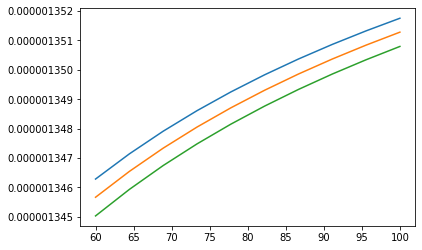

In [20]:
# Plot of the policy function with respect to consumption
plt.plot(capital, guess)
plt.show()

Having the policy function, we now can plot it.

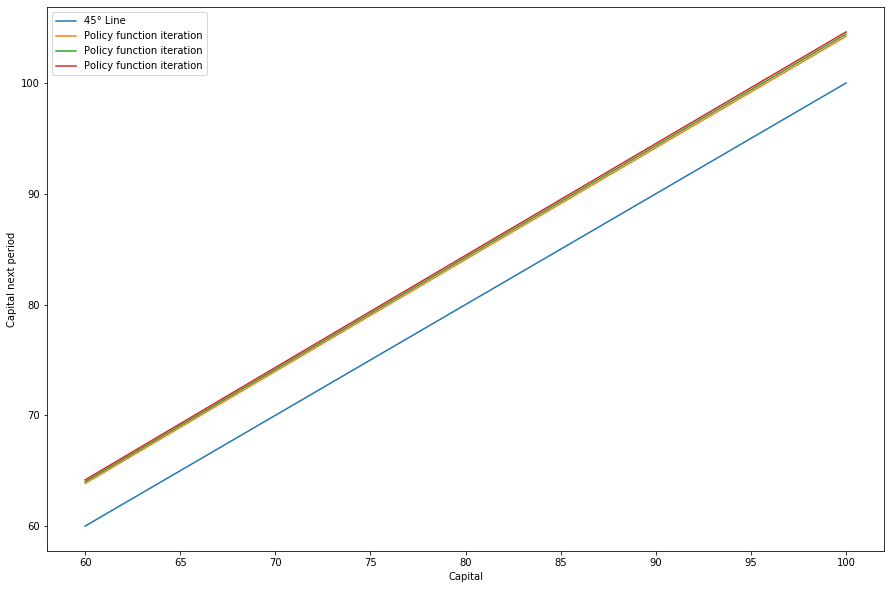

In [21]:
# Plotting the VFI, exact solution, and the policy function iteration solution
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, capital, label = "45° Line")
ax.plot(capital, policy, label = "Policy function iteration")
ax.set_xlabel("Capital")
ax.set_ylabel("Capital next period")
ax.legend(loc = 2)
plt.show()

Next let's find the steady state. We do this by finding the root of an excess function:

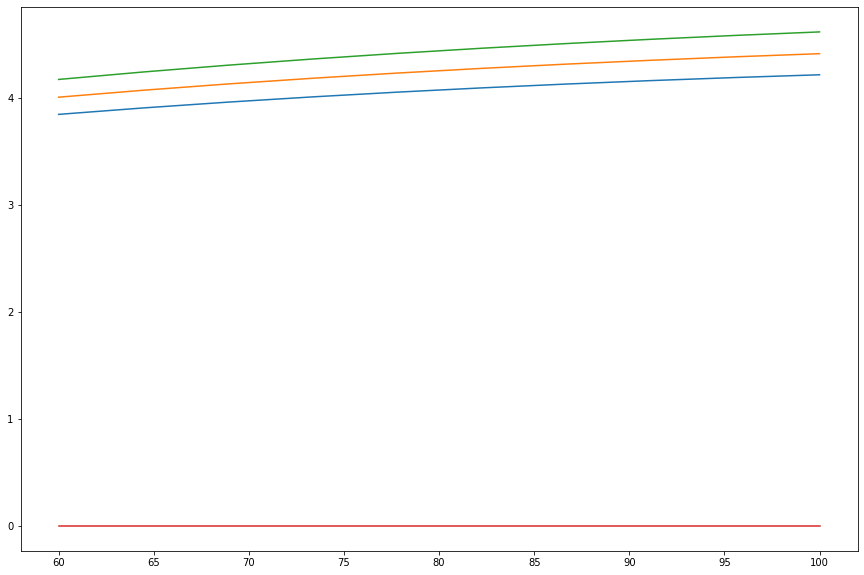

In [22]:
# To check, whether both generate the same steady state we find the root of the excess function:
def excess(pol, cap):
    ex = pol - cap
    return ex

# Generate the excess function
excess = excess(policy,kbar)

# Plot the excess function
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, excess, label = "Excess function")
ax.plot(capital, np.zeros(knum,))
plt.show()

In [ ]:
# Let's find the root
tck = interp.splrep(capital, excess[:,int(np.round((NS)/2))])
conexcess = lambda x: interp.splev(x, tck)

# Find the root
loc = opt.fsolve(conexcess, kss)
print("The numerical steady state of the model is %F, while the true steady state is %F" % (loc, kss))

Since we are rather satistfied with the precision, we now can simulate the economy.

In [ ]:
# Defining a function to simulate different trajectories
def simulate(k0, T, policy, guess):
    """Description of the function"""
    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, policy)
    polcap = lambda x: interp.splev(x, tck)

    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, guess)
    polcon = lambda x: interp.splev(x, tck)

    
    # Setting up the arrays holding the time series of the simulated economy
    consumption = np.zeros(T)
    investment = np.zeros(T)
    output = np.zeros(T)
    capital1 = np.zeros(T+1)
    capital1[0] = k0

    for t in np.arange(0,T):
        consumption[t] = polcon(capital1[t])
        output[t] = capital1[t]**alpha
        investment[t] = output[t] - consumption[t]
        capital1[t+1] = investment[t] + (1-delta)*capital1[t]
    
    return consumption, investment, output, capital1

# Simulating the time series behavior
con1, inv1, out1, cap1 = simulate(0.1*kss, T, policy, guess)
con2, inv2, out2, cap2 = simulate(1.2*kss, T, policy, guess)

Using the simulated behavior, we now can plot the development of different economies with different initial states.

In [ ]:
# Defining a time sequence and a vector with the kss
time = np.arange(0,T)
vkss = np.zeros(T)
vkss[:] = kss

# Plot the excess function
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))
axes[0,0].plot(time, cap1[0:T])
axes[0,0].plot(time, vkss, label = "Steady-State")
axes[0,0].set_title("Trajectory of capital")
axes[0,0].set_xlabel("Period")
axes[0,0].set_ylabel("Capital")

axes[0,1].plot(time, out1, label = "Output")
axes[0,1].plot(time, con1, label = "Consumption")
axes[0,1].plot(time, inv1, label = "Investment")
axes[0,1].set_title("GDP components")
axes[0,1].set_xlabel("Period")
axes[0,1].set_ylabel("GDP components")
axes[0,1].legend(loc=5)

axes[1,0].plot(time, cap2[0:T])
axes[1,0].set_title("Trajectory of capital")
axes[1,0].plot(time, vkss, label = "Steady-State")
axes[1,0].set_xlabel("Period")
axes[1,0].set_ylabel("Capital")

axes[1,1].plot(time, out2, label = "Output")
axes[1,1].plot(time, con2, label = "Consumption")
axes[1,1].plot(time, inv2, label = "Investment")
axes[1,1].set_title("GDP components")
axes[1,1].set_xlabel("Period")
axes[1,1].set_ylabel("GDP components")
axes[1,1].legend(loc=5)

plt.show()

Let's plot the phase diagram, showing the saddle path for the economy to transit to the steady state. The phase diagram shows the convergence path of the economy, and the function of values for which consumption and capital are constant. Consumption is constant, when capital is at it's steady state value. However, capital is constant, if the difference in capital between periods, is zero.

$$k_{t+1} = (1-\delta)k_t + i_t \\
k_{t+1} - k_t = i_t - \delta k_t \\
0 = i_t - \delta k_t \\
i_t = \delta k_t \\
y_t - c_t = \delta k_t \\
c_t = y_t - \delta k_t$$

In [ ]:
# Setting up some arrays
vkss = np.zeros(knum)
vkss[:] = kss              # Array for the value where consumption is constant
css = policy**alpha - delta*policy

# Plotting the phase diagram
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(policy, guess, label = "Saddle path")
ax.plot(vkss, guess, label = r"$\Delta c = 0$")
ax.plot(policy, css, label = r"$\Delta k = 0$")
ax.legend(loc=2)
plt.show()

The graph looks a bit different from what we know from the books. This is since the books as well portray the situation, where we have a capital stock so high, that all output is going into investment. To achieve this, we need to have:

$$c_t = 0 \\
y_t = \delta k_t \\
k_t^{\alpha} = \delta k_t \\
k_t^{\alpha} - \delta k_t = 0$$

Let's find how big $k_t$ needs to be for this to happen. We know that one solution to this equation would be $k_t = 0$, but we actually exclude this equilibrium, since in such an equilibrium there would not be production. Therefore, we can divide by $k_t$:

$$k_t^{\alpha-1} = \delta \\
k_t = \delta^{\frac{1}{\alpha-1}}$$

In [ ]:
# As derived from theory
loc1 = delta**(1/(alpha-1))

# Define the function
concave = lambda k: k**alpha - delta*k
loc2 = opt.fsolve(concave, 700)
print("The numerical value is %F, while the theoretical value is %F." % (loc1, loc2))

Since this number is very high, we do not continue here to show the whole phase diagram.

### Euler equation residual

THe euler equation residual is a way to compute the error we have in our approximation with the policy function.

$$EER(k) = S(k_t) - [\beta((1-\delta)+\alpha(k_{t+1})^{\alpha-1})]^{-\gamma}S(k_{t+1}) \\
\textrm{with } k_{t+1} = (1-\delta)k_t + k_t^\alpha - S(k_t)$$

Where $S(k_t)$ is the continuous policy function.

In [ ]:
# Interpolating the policy function
tck = interp.splrep(capital, guess)
pol = lambda x: interp.splev(x, tck)

# Using the interpolated policy function to compute the EER
EER = lambda k: pol(k)-((beta*((1-delta)+alpha*((1-delta)*k+k**alpha-pol(k))**(alpha-1)))**(-gamma))*pol((1-delta)*k+k**alpha-pol(k))
EEE = lambda k: (EER(k)/pol(k))

# Setting up the spacing of the grid for which we want to analyze the euler equation error (EEE)
m = (kmax-kmin)/knum

# Setting up the capital grid and calculating the error
k = np.arange(kmin,kmax,m)
error = np.zeros(knum)
for index, cap in enumerate(k):
    error[index] = EEE(cap)

# Plotting the EEE
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(k, error, label = "Euler equation error")
ax.set_xlabel("Current level of capital")
plt.show()

The euler equation error is actually defined as:

$$\max_k |\frac{EER(k)}{S(k)}|$$

It's economic interpretation is as follows: If an agent makes a decision on the allocation of 1000€, using the approximated decision rules, he would make an error of $1000*\max_k |\frac{EER(k)}{S(k)}|$€.

In [ ]:
print("The euler equation error is %F" % np.amax(np.abs(error)))
print("\nThis results in an error for the agent of %F €" % np.amax(np.abs(1000*error)))

As a result, the EEE is really small. This showes that our approximation is rather good.